<a href="https://colab.research.google.com/github/meenuraji/S15/blob/master/15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from datetime import datetime 
print("Current Date/Time: ", datetime.now())

Current Date/Time:  2020-05-21 19:44:30.597032


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import torch
import json
import torchvision
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm_notebook, tnrange
import numpy as np
import matplotlib.pyplot as plt
import io
from itertools import groupby
import cv2
from tqdm.auto import tqdm
from pathlib import Path
from time import time
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset , random_split
from PIL import Image
from torchvision.transforms import transforms
import os
from glob import glob
import torch
import torchvision
from torch import nn

In [0]:
cd 'drive/My Drive'

/content/drive/My Drive


In [0]:
BG_dir = '/content/drive/My Drive/bg'

In [0]:
BGFG_dir ='/content/drive/My Drive/fg_bg_000'

In [0]:
MSK_dir ='/content/drive/My Drive/fg_bg_mask_000'

In [0]:
DP_dir ='/content/drive/My Drive/depth_000'

In [0]:
scale_transform = transforms.Compose([
                  transforms.Resize((128,128)),
                  transforms.Grayscale(num_output_channels=3),
                  transforms.ToTensor(),
])

In [0]:

class MasterDataset(Dataset):
    def __init__(self,  transform= None, bg_files= None, fg_bg_files= None, ms_bg_files= None, dp_files= None):
    
        self.bg_files= bg_files
        self.fg_bg_files= fg_bg_files
        self.ms_bg_files= ms_bg_files
        self.dp_files= dp_files

        self.transform = transform

    def __len__(self):
        return len(self.bg_files)

    def __getitem__(self,index):
        bg_image = Image.open(self.bg_files[index])
        fg_bg_image = Image.open(self.fg_bg_files[index])
        ms_bg_image = Image.open(self.ms_bg_files[index])
        dp_image = Image.open(self.dp_files[index])

        if self.transform:
            bg_image = self.transform(bg_image)
            fg_bg_image = self.transform(fg_bg_image)
            ms_bg_image = self.transform(ms_bg_image)
            dp_image = self.transform(dp_image)
        return {'bg_image' : bg_image,'fg_bg_image' : fg_bg_image, 'ms_bg_image' : ms_bg_image, 'dp_image' : dp_image}


In [0]:
def getfiles(path= "./gdrive/My Drive/"):
    files_list = []
    
    files_list.extend(glob(os.path.join(os.path.join(path + str(), '*.jpg'))))
    files_list.extend(glob(os.path.join(os.path.join(path + str(), '*.jpeg'))))
    print("Total No of image is:  " + str(len(files_list)))
    return files_list

In [0]:
fg_bg_files= getfiles(BGFG_dir)
ms_bg_files= getfiles(MSK_dir)
dp_files= getfiles(DP_dir)
bg_files= getfiles(BG_dir)

Total No of image is:  7800
Total No of image is:  7800
Total No of image is:  7634
Total No of image is:  100


In [0]:

channel_means = (0.49139968, 0.48215841, 0.44653091)
channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
# Train Phase transformations
#mean, std = torch.tensor([0.5,0.5,0.5])*255,torch.tensor([0.2,0.2,0.2])*255
train_transforms = transforms.Compose([
                                       transforms.Resize((128,128)),
                                       transforms.Grayscale(num_output_channels=3),
                                       transforms.ToTensor()
])


fillmeans = (np.array(channel_means)).astype(np.uint8)



# Test Phase transformations
test_transforms = transforms.Compose([transforms.Normalize(mean=channel_means, std=channel_stdevs)])

In [0]:

train_ds = MasterDataset(train_transforms, bg_files, fg_bg_files, ms_bg_files, dp_files)
test_ds = MasterDataset(test_transforms, bg_files, fg_bg_files)

In [0]:
print(len(train_ds.bg_files))
print(len(train_ds.ms_bg_files))
print(len(train_ds.fg_bg_files))
print(len(train_ds.dp_files))

100
7800
7800
7634


In [0]:
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, pin_memory=True)

# test dataloader
test_loader = DataLoader(test_ds, batch_size=16, shuffle=True, pin_memory=True)

In [0]:
[(k, v.shape) for k, v in train_ds[0].items()]

[('bg_image', torch.Size([3, 128, 128])),
 ('fg_bg_image', torch.Size([3, 128, 128])),
 ('ms_bg_image', torch.Size([3, 128, 128])),
 ('dp_image', torch.Size([3, 128, 128]))]

In [0]:
sample = next(iter(train_loader))
type(sample)

dict

In [0]:
[(k, v.shape) for k, v in sample.items()]

[('bg_image', torch.Size([16, 3, 128, 128])),
 ('fg_bg_image', torch.Size([16, 3, 128, 128])),
 ('ms_bg_image', torch.Size([16, 3, 128, 128])),
 ('dp_image', torch.Size([16, 3, 128, 128]))]

In [0]:
imgs = sample["fg_bg_image"]

In [0]:
grid_tensor = torchvision.utils.make_grid(imgs,2)
grid_image = grid_tensor.permute(1,2,0)

In [0]:
def show(tensors, figsize=(10,10), *args, **kwargs):
    try:
        tensor =tensor.detach().cpu()
    except:
        pass
    grid_tensor = torchvision.utils.make_grid(tensors, *args, **kwargs)
    grid_image = grid_tensor.permute(1,2,0)
    plt.figure(figsize=figsize)
    plt.imshow(grid_image)
    plt.xticks([])
    plt.yticks([])

    plt.show()

def show_pred(tensors, *args, **kwargs):
    tensors = (tensors *std([None, None, None]) + mean[None, None, None])
    show(tensors, *args, **kwargs)


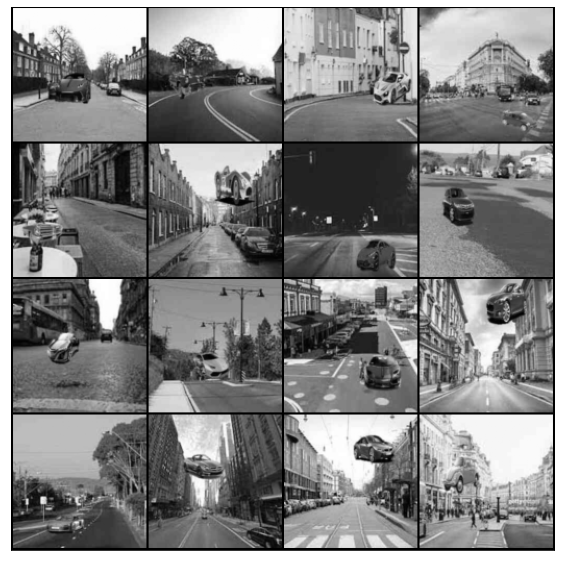

In [0]:
show(imgs, nrow=4)

In [0]:
import torch
import torchvision
import numpy as np
import pandas as pd
import torch.nn as nn                        # Import neural net module from pytorch
import torch.nn.functional as F              # Import functional interface from pytorch
import torch.optim as optim                  # Import optimizer module from pytorch
from torchsummary import summary             # Import summary with pytorch

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.input_layer = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=64, kernel_size=(3, 3), padding=(1, 1), stride=(1, 1), bias=False),
            nn.BatchNorm2d(64), 
            nn.ReLU()
        )
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=(1, 1), stride=(1, 1), bias=False),
            #nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.resblock1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=(1, 1), stride=(1, 1), bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=(1, 1), stride=(1, 1), bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=(1, 1), stride=(1, 1), bias=False),
            #nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), padding=(1, 1), stride=(1, 1), bias=False),
            #nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.resblock2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), padding=(1, 1), stride=(1, 1), bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), padding=(1, 1), stride=(1, 1), bias=False),
            nn.BatchNorm2d(256)
        )
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(256,3,3, stride=1, padding=1, bias=False)            
        ) 

    def forward(self, x):
        bg_image = x["bg_image"]
        fg_bg_image = x["fg_bg_image"] 
        x= torch.cat([bg_image,fg_bg_image], dim=1)
        x = self.input_layer(x)
        x = self.layer1(x)
        r1 = self.resblock1(x)
        x = x + r1
        x = self.layer2(x)
        x = self.layer3(x)
        r2 = self.resblock2(x)
        x = x + r2
        x = self.layer4(x)
        #print(x.shape)
        return x , x

In [0]:

from torch.nn.modules.module import _addindent
import torch
import numpy as np
def torch_summarize(model, show_weights=True, show_parameters=True):
    """Summarizes torch model by showing trainable parameters and weights."""
    tmpstr = model.__class__.__name__ + ' (\n'
    for key, module in model._modules.items():
        # if it contains layers let call it recursively to get params and weights
        if type(module) in [
            torch.nn.modules.container.Container,
            torch.nn.modules.container.Sequential
        ]:
            modstr = torch_summarize(module)
        else:
            modstr = module.__repr__()
        modstr = _addindent(modstr, 2)
        params = sum([np.prod(p.size()) for p in module.parameters()])
        weights = tuple([tuple(p.size()) for p in module.parameters()])
        tmpstr += '  (' + key + '): ' + modstr 
        if show_weights:
            tmpstr += ', weights={}'.format(weights)
        if show_parameters:
            tmpstr +=  ', parameters={}'.format(params)
        tmpstr += '\n'
    tmpstr = tmpstr + ')'
    return tmpstr

#print(torch_summarize(model))

In [0]:
class ConvGen(nn.Module):
    def __init__(self):
        super(ConvGen, self).__init__()

        self.convblock1 = nn.Sequential(
            nn.Conv2d(3,32,3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.convblock2 = nn.Sequential(
            nn.Conv2d(32,32,3, stride=1, padding=1, bias=False, groups=32),
            nn.Conv2d(32,64,1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.convblock3 = nn.Sequential(
            nn.Conv2d(128,256,3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.convblock4 = nn.Sequential(
            nn.Conv2d(256,3,3, stride=1, padding=1, bias=False)            
        )
        
    def forward(self, x):
        bg_image = x["bg_image"]
        fg_bg_image = x["fg_bg_image"]        
        bg_image = self.convblock2(self.convblock1(bg_image))
        fg_bg_image = self.convblock2(self.convblock1(fg_bg_image))
        f= torch.cat([bg_image,fg_bg_image], dim=1)
        #print(f.shape)
        f = self.convblock4(self.convblock3(f))
        #print(f.shape)
        return f, f

In [0]:
from torchsummary import summary
model = ConvGen()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model= model.to(device)
#print(model)
#summary(model, (3, 64, 64))
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

305728


In [0]:

criterion = nn.BCEWithLogitsLoss()
#criterion = SSIM(3, reduction="mean" )
optim = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9, weight_decay = 1e-5)

In [0]:
#PATH= './saved_models/'
#model.load_state_dict(torch.load(PATH + '0.pth'))
PATH= Path('/content/drive/My Drive/S15') 
PATH.mkdir(exist_ok= True)

In [0]:
def draw_save(tensors, name, figsize=(10,10), *args, **kwargs):
  try:
    tensors = tensors.detach().cpu()
  except: 
    pass
  grid_tensor1= torchvision.utils.make_grid(tensors,*args, **kwargs)
  grid_image1= grid_tensor1.permute(1,2,0)
  plt.figure(figsize=figsize)
  plt.imshow(grid_image1)
  plt.xticks([])
  plt.yticks([])
  plt.savefig(name, bbox_inches = 'tight')
  plt.show()

In [0]:

def train( model, criterion, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  for batch_idx, data in enumerate(pbar):
    data["bg_image"] = data["bg_image"].to(device)
    data["fg_bg_image"] = data["fg_bg_image"].to(device)
    data["ms_bg_image"] = data["ms_bg_image"].to(device)
    data["dp_image"] = data["dp_image"].to(device)
    optimizer.zero_grad()
    output=model(data)    
    #loss= criterion(output,data["ms_bg_image"])
    loss1 = criterion(output[0],data["ms_bg_image"])
    loss2 = criterion(output[1],data["dp_image"])
    loss = 2*loss1 + loss2
    pbar.set_description(desc= f'l1={round(loss1.item(),4)} l2={round(loss2.item(),4)}')
    loss.backward()
    optimizer.step()
    if batch_idx % 50 == 0:
      print('Train Epoch : {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch,batch_idx*len(data),len(train_loader.dataset), 
                                                                      100.*batch_idx/len(train_loader), loss.item()))
    if batch_idx % 5000 == 0:
      draw_save(output[0], f"/{epoch}_{batch_idx}_PMS_{loss1.item()}.jpg")
      draw_save(output[1], f"/{epoch}_{batch_idx}_PDP_{loss2.item()}.jpg")
      draw_save(data["ms_bg_image"], f"/{epoch}_{batch_idx}_MS_{loss.item()}.jpg")
      draw_save(data["dp_image"], f"/{epoch}_{batch_idx}_DP_{loss.item()}.jpg")
      draw_save(data["fg_bg_image"], f"/{epoch}_{batch_idx}_BG_{loss.item()}.jpg")

    #if batch_idx % 5000 == 0:
    #  show_pred(output.detach().cpu,nrow=2)
    #  show(output,nrow=4)
    if batch_idx % 50 == 0:
      torch.save(model.state_dict(), PATH/f"{batch_idx}.pth")

In [0]:
from torch.optim.lr_scheduler import StepLR
#device = torch.device('cuda:0')
#model= model.to(device)
scheduler= StepLR(optim, step_size=1, gamma= 0.01)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch : 1 [0/100 (0%)]	Loss: 2.144778


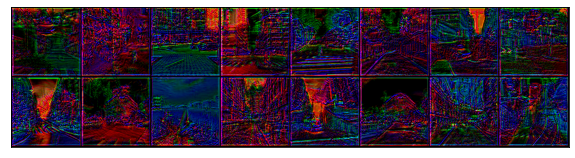

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


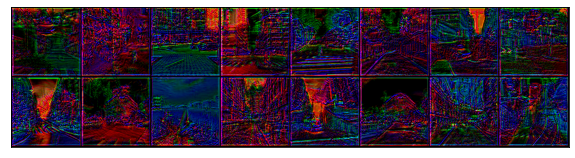

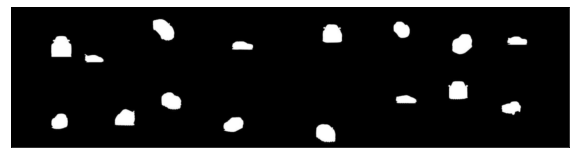

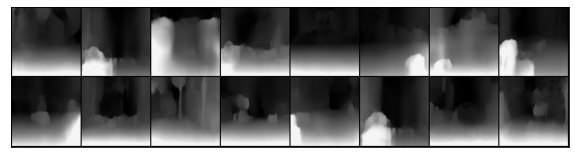

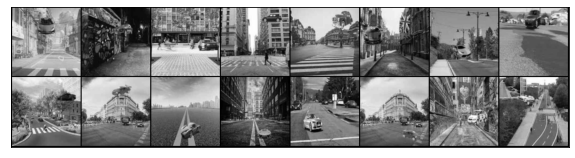

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch : 2 [0/100 (0%)]	Loss: 1.459841


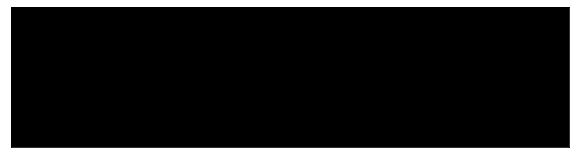

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


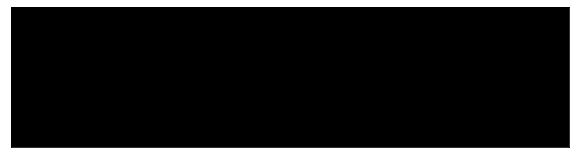

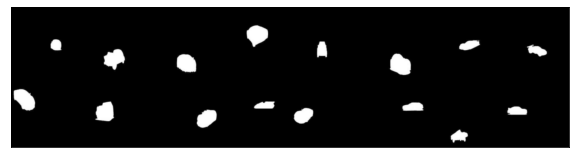

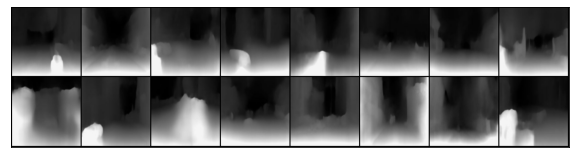

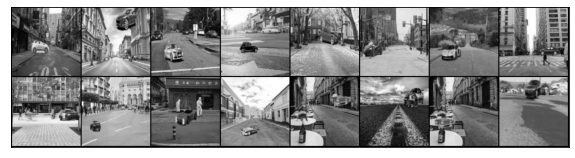

In [0]:

for epoch in range(1,3):
  train(model, criterion,device, train_loader, optim, epoch)
  scheduler.step()